# BDP - Cloud Storage Workshop

**Exercise notebook**

---

We will imitate working on the cloud:

* Your computer's disk as **Object Storage**.
* The **Big Data Engine** will be DuckDB (a high-performance analytical database system).
* The **BI tool** is jupyter.

---

**SETUP**

We will use a slightly older version of pandas and pyarrow<br>
pandas uses pyarrow as the default engine to handle parquet files

In [ ]:
#!pip install numpy==1.23.5 -q
!pip install pandas==1.1.5 -q
!pip install pyarrow==2.0.0 -q

In [1]:
!pip list

Package                       Version
----------------------------- ---------
appnope                       0.1.3
asttokens                     2.2.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
certifi                       2022.12.7
comm                          0.1.2
debugpy                       1.6.4
decorator                     5.1.1
entrypoints                   0.4
executing                     1.2.0
ipykernel                     6.19.4
ipython                       8.7.0
jedi                          0.18.2
jupyter_client                7.4.8
jupyter_core                  5.1.0
matplotlib-inline             0.1.6
nest-asyncio                  1.5.6
numpy                         1.23.5
packaging                     22.0
pandas                        1.1.5
parso                         0.8.3
pexpect                       4.8.0
pickleshare                   0.7.5
pip                           22.3.1
platformdirs                  2.6.0
prompt-toolkit   

In [2]:
import pandas as pd
import numpy as np

For the following exercises we will generate a dataset and store it locally (as a parquet file and as a csv file).

In [2]:
def generate_data():

    date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-01-07 23:00:00', freq='S').astype(str)

    index = np.random.choice(date_range, size=AMOUNT_OF_ROWS)
    user_id = np.random.randint(1_000_000, 9_999_999, size=AMOUNT_OF_ROWS)
    platform = np.random.choice(['Android', 'iOS', 'Amazon'], p=[0.5, 0.45, 0.05], size=AMOUNT_OF_ROWS)
    transaction_id = np.random.randint(10_000_000_000, 10_123_999_999, size=AMOUNT_OF_ROWS)
    purchases = np.random.choice([0.99, 1.99, 2.99, 3.99, 4.99, 5.99, 9.99, 19.99], p=[0.2, 0.3, 0.25, 0.1, 0.05, 0.05, 0.04, 0.01], size=AMOUNT_OF_ROWS)
    session_time = (np.random.random(size=AMOUNT_OF_ROWS) * 10).round(2)
    
    df = pd.DataFrame({'timestamp': index, 'user_id': user_id, 'platform': platform,
                       'transaction_id': transaction_id, 'purchases': purchases, 'session_time': session_time})
    
    df['dtstring'] = pd.to_datetime(df['timestamp']).dt.strftime('%Y%m%d')
    
    return df

In [3]:
AMOUNT_OF_ROWS = 1_000_000

In [46]:
np.random.seed(42)  # For the code to be reproducible

df = generate_data()

In [49]:
df

,timestamp,user_id,platform,transaction_id,purchases,session_time,dtstring
0,2023-01-02 09:52:38,2835593,Android,10063790287,1.99,4.93,20230102
1,2023-01-02 12:38:52,6680066,Android,10060916279,2.99,0.56,20230102
2,2023-01-05 05:37:18,8130325,Amazon,10122100727,2.99,7.04,20230105
3,2023-01-03 23:59:38,1359593,Android,10063851029,0.99,9.10,20230103
4,2023-01-02 06:37:48,9443113,Amazon,10077476400,5.99,9.59,20230102
...,...,...,...,...,...,...,...
999995,2023-01-07 13:23:00,7700528,iOS,10032616175,2.99,2.99,20230107
999996,2023-01-07 18:34:30,4498226,Android,10088295033,2.99,5.15,20230107
999997,2023-01-03 14:50:25,9066966,iOS,10094817932,9.99,4.42,20230103
999998,2023-01-02 14:54:36,5350617,iOS,10104146265,4.99,1.17,20230102


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   timestamp       1000000 non-null  object 
 1   user_id         1000000 non-null  int64  
 2   platform        1000000 non-null  object 
 3   transaction_id  1000000 non-null  int64  
 4   purchases       1000000 non-null  float64
 5   session_time    1000000 non-null  float64
 6   dtstring        1000000 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 53.4+ MB


---

In [7]:
import os

In [5]:
parquet_path = os.getcwd() + '/parquets'
csv_path = os.getcwd() + '/my_data.csv'

In [105]:
df.to_parquet(path=parquet_path, index=False, partition_cols=['dtstring'], compression='gzip',
              use_legacy_dataset=True, partition_filename_cb=lambda x: '_'.join(x) + '.parquet')

In [44]:
df.to_csv(csv_path, index=False)

---

### Size comparison csv vs parquet

In [16]:
def size_mb(size_bytes):
    size_in_gb = round(size_bytes / 1024**2, 2)
    print(size_in_gb, 'MB')

**CSV:**

In [17]:
size_csv = os.path.getsize(csv_path)

In [18]:
size_mb(size_csv)

62.05 MB


**Parquet:**

In [19]:
total_size_parquet = 0
for folder in os.listdir(parquet_path):
    for file in os.listdir('/'.join([parquet_path, folder])):
        if '.parquet' in file:
            total_size_parquet += os.path.getsize('/'.join([parquet_path, folder, file]))

In [20]:
size_mb(total_size_parquet)

17.16 MB


---

### Comparison of reading data from csv vs parquet

Open a csv file

In [51]:
%%time

pd.read_csv(csv_path)

CPU times: user 3.47 s, sys: 148 ms, total: 3.62 s
Wall time: 3.65 s


,timestamp,user_id,platform,transaction_id,purchases,session_time,dtstring
767140,2023-01-01 00:00:00,1420129,iOS,10110867501,3.99,0.49,20230101
141037,2023-01-01 00:00:01,9471506,Android,10066668058,1.99,9.98,20230101
927430,2023-01-01 00:00:01,4003934,Android,10071966072,5.99,9.40,20230101
754232,2023-01-01 00:00:01,5927031,Android,10059370637,5.99,1.15,20230101
624536,2023-01-01 00:00:03,9911830,iOS,10086163141,2.99,1.63,20230101
...,...,...,...,...,...,...,...
82515,2023-01-07 22:59:58,3370924,iOS,10101966229,9.99,1.06,20230107
246825,2023-01-07 22:59:59,9646512,Android,10048628637,1.99,2.00,20230107
925057,2023-01-07 22:59:59,9094269,iOS,10080487051,1.99,1.08,20230107
451832,2023-01-07 22:59:59,3069866,iOS,10083839209,5.99,8.47,20230107


Open a parquet file

In [159]:
%%time

pd.read_parquet(path=parquet_path)

CPU times: user 554 ms, sys: 212 ms, total: 765 ms
Wall time: 402 ms


,timestamp,user_id,platform,transaction_id,purchases,session_time,dtstring
0,2023-01-01 15:14:46,8091778,iOS,10016276618,1.99,9.40,20230101
1,2023-01-01 11:24:50,9450006,Android,10006525813,1.99,9.39,20230101
2,2023-01-01 18:00:20,1047741,Android,10018949892,0.99,5.73,20230101
3,2023-01-01 18:15:25,5798766,iOS,10035565251,1.99,8.54,20230101
4,2023-01-01 23:30:54,3044111,Android,10021052651,1.99,1.93,20230101
...,...,...,...,...,...,...,...
999995,2023-01-07 00:41:22,1278663,Android,10121537471,2.99,7.74,20230107
999996,2023-01-07 19:40:22,8098390,Android,10033032840,0.99,3.79,20230107
999997,2023-01-07 13:23:00,7700528,iOS,10032616175,2.99,2.99,20230107
999998,2023-01-07 18:34:30,4498226,Android,10088295033,2.99,5.15,20230107


---

For the following questions:

Use the %%time magic command, timeit module or other benchmarking tools to measure the difference in performance.

Your code output will be with different values from the output cells, they exists as a reference.<br>
Be careful not to run the output cell (the output will disapper).

## Question 1 (Columnar Storage):

Fetch and display only the purchases column and compare the performance of csv vs parquet.<br>

*HINT: Take advantage of the parquet's columnar architecture*

**CSV:**

In [37]:
%%time
# YOUR CODE
pd.read_csv(csv_path, usecols=['purchases'])

CPU times: user 279 ms, sys: 44.6 ms, total: 323 ms
Wall time: 325 ms


,purchases
0,1.99
1,2.99
2,2.99
3,0.99
4,5.99
...,...
999995,2.99
999996,2.99
999997,9.99
999998,4.99


In [19]:
## REQUIRED OUTPUT

CPU times: user 811 ms, sys: 100 ms, total: 912 ms
Wall time: 911 ms


,purchases
0,1.99
1,3.99
2,2.99
3,2.99
4,1.99
...,...
999995,1.99
999996,2.99
999997,0.99
999998,1.99


**Parquet:**

In [8]:
%%time
# YOUR CODE
pd.read_parquet(path=parquet_path, columns=['purchases'])

CPU times: user 19.5 ms, sys: 15.4 ms, total: 34.9 ms
Wall time: 30.9 ms


,purchases
0,1.99
1,1.99
2,0.99
3,1.99
4,1.99
...,...
999995,2.99
999996,0.99
999997,2.99
999998,2.99


In [20]:
## REQUIRED OUTPUT

CPU times: user 16 ms, sys: 11.9 ms, total: 27.8 ms
Wall time: 14.7 ms


,purchases
0,19.99
1,0.99
2,9.99
3,0.99
4,1.99
...,...
999995,2.99
999996,2.99
999997,1.99
999998,2.99


---

## Question 2 (Predicate Pushdown):

Fetch and display only the purchases column (as in question 1), but only for the first day of the year.<br>
Compare the performance of csv vs parquet.<br>

*HINT: Take advantage of the parquet's predicate pushdown capability*

In [4]:
from datetime import date

**CSV:**

In [6]:
%time
# YOUR CODE
df_csv = pd.read_csv(csv_path, usecols=['purchases', 'dtstring'], parse_dates=['dtstring'])

# Filter the dataframe to include only the first day of the year
df_csv[df_csv['dtstring'].dt.date == date(2023, 1, 1)][['purchases']]


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


,purchases
5,1.99
12,1.99
14,0.99
32,1.99
34,1.99
...,...
999969,1.99
999971,2.99
999975,1.99
999987,2.99


In [21]:
## REQUIRED OUTPUT

CPU times: user 818 ms, sys: 115 ms, total: 933 ms
Wall time: 933 ms


,purchases
5,19.99
12,0.99
14,9.99
32,0.99
34,1.99
...,...
999969,2.99
999971,1.99
999975,1.99
999987,1.99


**Parquet:**

In [135]:
import pyarrow.dataset as ds

In [16]:
%%time
df_parquet = pd.read_parquet(path=parquet_path, columns=['purchases', 'dtstring'])
type(df_parquet)
#df_parquet.query("dtstring == 20230101")[['purchases']]

CPU times: user 31.1 ms, sys: 17.9 ms, total: 49 ms
Wall time: 22.8 ms


pandas.core.frame.DataFrame

In [7]:
%%time
# Open the Parquet dataset
dataset = ds.dataset(parquet_path, format="parquet", partitioning="hive")

#dataset.to_table().to_pandas().head()
dataset.to_table(columns=["purchases"], filter=ds.field("dtstring") == "20230101").to_pandas()


CPU times: user 7.27 ms, sys: 14.2 ms, total: 21.5 ms
Wall time: 73 ms


,purchases
0,1.99
1,1.99
2,0.99
3,1.99
4,1.99
...,...
144511,1.99
144512,2.99
144513,1.99
144514,2.99


In [22]:
## REQUIRED OUTPUT

CPU times: user 4.67 ms, sys: 3.38 ms, total: 8.05 ms
Wall time: 7.07 ms


,purchases
0,19.99
1,0.99
2,9.99
3,0.99
4,1.99
...,...
144511,2.99
144512,1.99
144513,1.99
144514,1.99


---

## Question 3 (Big Data Engine, sorting):

Return the 10 first transactions of 2023, show the timestamp, transaction_id and the purchases.<br>

**CSV:**

In [156]:
%%time

# Read the CSV file and select the desired columns
df_csv = pd.read_csv(csv_path, usecols=['timestamp', 'transaction_id', 'purchases'], parse_dates=['timestamp'])

# Convert the timestamp column to a datetime and extract the year
df_csv['year'] = pd.to_datetime(df_csv['timestamp']).dt.year

# Filter the dataframe to include only transactions from 2023
df_csv = df_csv[df_csv['year'] == 2023]

# Select the first 10 rows and the desired columns
df_csv = df_csv.sort_values("timestamp").head(10)[['timestamp', 'transaction_id', 'purchases']]

# Display the resulting dataframe
df_csv


CPU times: user 1.15 s, sys: 152 ms, total: 1.3 s
Wall time: 1.31 s


,timestamp,transaction_id,purchases
767140,2023-01-01 00:00:00,10110867501,3.99
141037,2023-01-01 00:00:01,10066668058,1.99
927430,2023-01-01 00:00:01,10071966072,5.99
754232,2023-01-01 00:00:01,10059370637,5.99
624536,2023-01-01 00:00:03,10086163141,2.99
91568,2023-01-01 00:00:03,10024786933,0.99
278449,2023-01-01 00:00:04,10021016913,2.99
483866,2023-01-01 00:00:04,10090801772,0.99
988344,2023-01-01 00:00:05,10049220525,2.99
11773,2023-01-01 00:00:05,10122511897,1.99


In [23]:
## REQUIRED OUTPUT

CPU times: user 943 ms, sys: 82.1 ms, total: 1.03 s
Wall time: 1.02 s


,timestamp,transaction_id,purchases
767140,2023-01-01 00:00:00,10030305175627,3.99
141037,2023-01-01 00:00:01,10077082828374,2.99
754232,2023-01-01 00:00:01,10053993818098,2.99
927430,2023-01-01 00:00:01,10122520668509,0.99
91568,2023-01-01 00:00:03,10014666691673,1.99
624536,2023-01-01 00:00:03,10012296032974,0.99
278449,2023-01-01 00:00:04,10060205823742,2.99
483866,2023-01-01 00:00:04,10103842269074,3.99
988344,2023-01-01 00:00:05,10054744018806,2.99
11773,2023-01-01 00:00:05,10048069563577,3.99


**Pandas (parquet):**

In [9]:
import pyarrow as pa
import pyarrow.dataset as ds

# Open the Parquet dataset
dataset = ds.dataset(parquet_path, format="parquet", partitioning="hive")

# Select only the timestamp, transaction_id, and purchases columns
table = dataset.to_table(columns=["timestamp", "transaction_id", "purchases"])

# Convert the timestamp column to a datetime and extract the year
table = table.select([table.column("timestamp").cast(pa.timestamp('s')).year.rename("year")])

# Filter the table to include only transactions from 2023
table = table.filter(table.column("year") == 2023)

# Select the first 10 rows and the desired columns
table = table.head(10).select([table.column("timestamp"), table.column("transaction_id"), table.column("purchases")])

# Convert the table to a pandas dataframe
df_parquet = table.to_pandas()

# Display the resulting dataframe
print(df_parquet)


AttributeError: 'pyarrow.lib.ChunkedArray' object has no attribute 'year'

In [219]:
table.column("timestamp").cast(pa.timestamp('s'))

[
  [
    2023-01-01 15:14:46,
    2023-01-01 11:24:50,
    2023-01-01 18:00:20,
    2023-01-01 18:15:25,
    2023-01-01 23:30:54,
    2023-01-01 18:55:48,
    2023-01-01 06:27:27,
    2023-01-01 06:45:00,
    2023-01-01 13:36:24,
    2023-01-01 03:53:06,
    ...
    2023-01-07 10:35:18,
    2023-01-07 11:43:01,
    2023-01-07 18:55:08,
    2023-01-07 06:39:55,
    2023-01-07 16:51:02,
    2023-01-07 00:41:22,
    2023-01-07 19:40:22,
    2023-01-07 13:23:00,
    2023-01-07 18:34:30,
    2023-01-07 12:31:06
  ]
]

In [24]:
## REQUIRED OUTPUT

CPU times: user 182 ms, sys: 23.6 ms, total: 206 ms
Wall time: 206 ms


,timestamp,transaction_id,purchases
111132,2023-01-01 00:00:00,10030305175627,3.99
20454,2023-01-01 00:00:01,10077082828374,2.99
109267,2023-01-01 00:00:01,10053993818098,2.99
134102,2023-01-01 00:00:01,10122520668509,0.99
13297,2023-01-01 00:00:03,10014666691673,1.99
90560,2023-01-01 00:00:03,10012296032974,0.99
40473,2023-01-01 00:00:04,10060205823742,2.99
70292,2023-01-01 00:00:04,10103842269074,3.99
142817,2023-01-01 00:00:05,10054744018806,2.99
1646,2023-01-01 00:00:05,10048069563577,3.99


Incorporate a Big Data Engine (DuckDB) to read the parquet files faster (in parallel).

**Big Data Engine (parquet):**

In [220]:
!pip install duckdb -q

In [221]:
import duckdb

In [222]:
con = duckdb.connect()
con.execute("PRAGMA threads=8");

# We will use HIVE partitioning format and mimic working against object storage
object_storage = "parquet_scan('parquets/*/*', HIVE_PARTITIONING=1)"

In [223]:
example_query = f"""

SELECT *
FROM {object_storage}

"""

con.execute(example_query).df()

,timestamp,user_id,platform,transaction_id,purchases,session_time,dtstring
0,2023-01-05 05:37:18,8130325,Amazon,10122100727,2.99,7.04,20230105
1,2023-01-05 00:30:49,8801489,iOS,10068883639,2.99,9.31,20230105
2,2023-01-05 21:11:49,9140602,Android,10096474109,4.99,5.09,20230105
3,2023-01-05 10:51:21,1095977,iOS,10043946892,4.99,3.01,20230105
4,2023-01-05 01:04:17,9380299,Android,10076376936,4.99,1.11,20230105
...,...,...,...,...,...,...,...
999995,2023-01-07 00:41:22,1278663,Android,10121537471,2.99,7.74,20230107
999996,2023-01-07 19:40:22,8098390,Android,10033032840,0.99,3.79,20230107
999997,2023-01-07 13:23:00,7700528,iOS,10032616175,2.99,2.99,20230107
999998,2023-01-07 18:34:30,4498226,Android,10088295033,2.99,5.15,20230107


In [257]:
# YOUR CODE
example_query = f"""
SELECT timestamp, transaction_id, purchases, EXTRACT(YEAR FROM timestamp) BETWEEN 2020 AND 2022
FROM {object_storage}
"""
# Execute the query and retrieve the results as a pandas dataframe
df = con.execute(example_query).df()

# Select the first 10 rows and the desired columns
df[['timestamp', 'transaction_id', 'purchases']]

BinderException: Binder Error: No function matches the given name and argument types 'date_part(VARCHAR, VARCHAR)'. You might need to add explicit type casts.
	Candidate functions:
	date_part(VARCHAR, TIMESTAMP WITH TIME ZONE) -> BIGINT
	date_part(VARCHAR[], TIMESTAMP WITH TIME ZONE) -> STRUCT()
	date_part(VARCHAR, DATE) -> BIGINT
	date_part(VARCHAR, TIMESTAMP) -> BIGINT
	date_part(VARCHAR, TIME) -> BIGINT
	date_part(VARCHAR, INTERVAL) -> BIGINT
	date_part(VARCHAR[], DATE) -> STRUCT()
	date_part(VARCHAR[], TIMESTAMP) -> STRUCT()
	date_part(VARCHAR[], TIME) -> STRUCT()
	date_part(VARCHAR[], INTERVAL) -> STRUCT()

LINE 2: ...T timestamp, transaction_id, purchases, EXTRACT(YEAR FROM timestamp) BETWEEN 2...
                                                  ^

In [29]:
## REQUIRED OUTPUT

CPU times: user 39.9 ms, sys: 5.87 ms, total: 45.8 ms
Wall time: 44.8 ms


,timestamp,transaction_id,purchases
0,2023-01-01 00:00:00,10030305175627,3.99
1,2023-01-01 00:00:01,10053993818098,2.99
2,2023-01-01 00:00:01,10122520668509,0.99
3,2023-01-01 00:00:01,10077082828374,2.99
4,2023-01-01 00:00:03,10012296032974,0.99
5,2023-01-01 00:00:03,10014666691673,1.99
6,2023-01-01 00:00:04,10103842269074,3.99
7,2023-01-01 00:00:04,10060205823742,2.99
8,2023-01-01 00:00:05,10048069563577,3.99
9,2023-01-01 00:00:05,10054744018806,2.99


---

## Question 4 (Big Data Engine, aggregation):

**Pandas (parquet):**

In [ ]:
# YOUR CODE

In [30]:
## REQUIRED OUTPUT

CPU times: user 126 ms, sys: 41.1 ms, total: 167 ms
Wall time: 107 ms


,purchases
platform,
Amazon,153859.39
Android,1544756.64
iOS,1392506.97


**Big Data Engine (parquet):**

In [ ]:
# YOUR CODE

In [31]:
## REQUIRED OUTPUT

CPU times: user 41.2 ms, sys: 7.3 ms, total: 48.5 ms
Wall time: 13.8 ms


,platform,purchases
0,iOS,1392506.97
1,Android,1544756.64
2,Amazon,153859.39


---

## Question 5 (BI):

Display the purchases over time, seperating between each one of the device platforms, the data manipulations should be in SQL only.

In [ ]:
# YOUR CODE

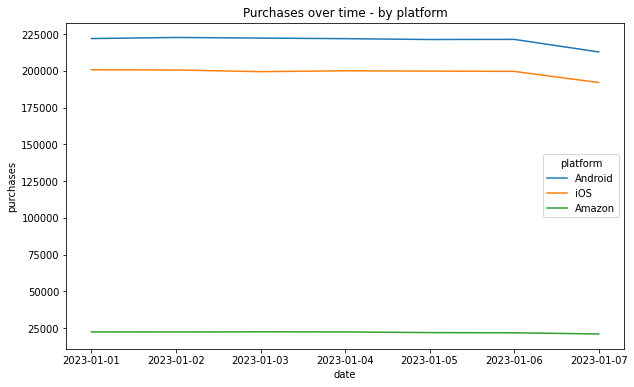

In [33]:
## REQUIRED OUTPUT

---

## Question 6 (Scalabilty):

Re-run the notebook with:<br>
**AMOUNT_OF_ROWS = 20_000_000**<br>

~1 GB for this type of data

“Big data” is a term relative to the available computing and storage power on the market.
- In 1999, one gigabyte (1 GB) was considered big data.
- Today, it is usually consists petabytes (1,024 terabytes) or exabytes (1,024 petabytes) of data.

1) **Do you see change in the benchmarks?**<br>

2) **What you think would happen if you run the notebook with 1B rows? which cells wouldn't run?**

3) **Try to re-run the notebook and sort the dataframe by timestamp before the partitioning process.**
* What happend to the folder size?
* Try to run a query which filters just 1 hour of data and compare the run time against the orginal partition process, what happend?

Remember to delete the files from your computer, so you can free this 1 GB :)

---